<a href="https://colab.research.google.com/github/anadiedrichs/curso_deep_learning/blob/main/Transfer_Learning_con_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

## Introducción

Vamos a introducir el aprendizaje por transferncia utilizando una analogía. Imagina que un estudiante de medicina ya conoce la anatomía del cuerpo humano. Si luego necesita especializarse en cardiología, no tiene que aprender la anatomía desde cero. En cambio, reutiliza su conocimiento previo y se enfoca en los detalles específicos del corazón. Esto es transfer learning.

En redes neuronales, el modelo pre-entrenado ha aprendido a reconocer características y patrones genéricos a partir de un gran conjunto de datos de origen. Por ejemplo, un modelo entrenado en ImageNet ha aprendido a detectar bordes, texturas, formas y patrones complejos. Estas características son útiles para una amplia gama de tareas de visión por computadora.

En la práctica, muy pocas personas entrenan una Red Convolucional (ConvNet) completa desde cero (con inicialización aleatoria), ya que es relativamente raro contar con un conjunto de datos de tamaño suficiente. En cambio, es común preentrenar una ConvNet con un conjunto de datos muy grande (p. ej., ImageNet, que contiene 1,2 millones de imágenes con 1000 categorías) y luego usarla como inicialización o como extractor de características fijas para la tarea de interés.

# Técnicas de TL

* ConvNet como fixed feature extractor
* ConvNet Finetunning

## ¿Qué son las redes pre entrenadas?


Una red neuronal pre entrenada es un modelo de aprendizaje automático que ha sido entrenado en un gran conjunto de datos para una tarea específica, como la clasificación de imágenes o el procesamiento de lenguaje natural. En lugar de construir y entrenar un modelo desde cero, se puede utilizar uno de estos modelos y simplemente ajustarlo para una nueva tarea, lo que ahorra tiempo y recursos computacionales. Este proceso se conoce como aprendizaje por transferencia.



## Dónde encontrar redes pre entrenadas y cómo han sido entrenadas

Las redes pre entrenadas más populares se encuentran en repositorios y bibliotecas de aprendizaje automático. A continuación, algunos de los más utilizados:

* TensorFlow Hub y Keras Applications: Estos son repositorios de Google que ofrecen una amplia variedad de modelos para visión por computadora y procesamiento de lenguaje natural. Un ejemplo popular es el modelo MobileNetV2. Se puede explicar que MobileNetV2 fue entrenado en el conjunto de datos ImageNet, que contiene millones de imágenes de más de 1000 categorías diferentes.

* PyTorch Hub: La biblioteca PyTorch también tiene su propio centro de modelos, con redes como ResNet y VGG, que también fueron entrenadas en ImageNet.

* Hugging Face: Este es el lugar ideal para modelos de procesamiento de lenguaje natural (PLN), como BERT y GPT. Se puede explicar que BERT fue entrenado en un enorme corpus de texto que incluye la Wikipedia y el BookCorpus para aprender a predecir palabras faltantes y oraciones, mientras que los modelos GPT han sido entrenados con miles de millones de páginas de texto de internet.


## ConvNet como extractor de características fijo ( fixed feature extractor)

 En este caso, congelamos los pesos de toda la red, excepto los de la capa final completamente conectada. Esta última capa completamente conectada se reemplaza por una nueva con pesos aleatorios y solo se entrena esta capa.

Esta segunda estrategia, el ajuste de la ConvNet, consiste no solo en reemplazar y reentrenar el clasificador sobre la ConvNet en el nuevo conjunto de datos, sino también en ajustar los pesos de la red preentrenada continuando la retropropagación. Es posible ajustar todas las capas de la ConvNet, o bien, mantener fijas algunas de las capas anteriores (debido a problemas de sobreajuste) y ajustar solo una parte de la red de nivel superior. Esto se debe a la observación de que las características iniciales de una ConvNet contienen características más genéricas (por ejemplo, detectores de bordes o de manchas de color) que deberían ser útiles para diversas tareas, pero las capas posteriores de la ConvNet se vuelven progresivamente más específicas respecto a los detalles de las clases contenidas en el conjunto de datos original.

En el caso de ImageNet, por ejemplo, que contiene numerosas razas de perros, una parte significativa de su capacidad de representación puede dedicarse a características específicas para diferenciar entre razas de perros.

### 1. Configuración de parámetros y dispositivo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Configuración de parámetros y dispositivo ---
# Usamos la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 2. Preparación de datos

In [2]:
# --- 2. Preparación de datos ---
# Define las transformaciones para las imágenes
# Nota: Las transformaciones deben coincidir con lo que el modelo pre-entrenado espera (por ejemplo, normalización para ImageNet)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
# Carga los datasets públicos (CIFAR-10)
# 'root' es el directorio donde se descargarán los datos
data_dir = './data'
image_datasets = {
    'train': datasets.CIFAR10(root=data_dir, train=True, download=True, transform=data_transforms['train']),
    'val': datasets.CIFAR10(root=data_dir, train=False, download=True, transform=data_transforms['val'])
}

# Crea los DataLoaders para iterar sobre los datos
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Clases de CIFAR-10
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")


Número de clases: 10


### 3. Función para visualizar las transformaciones

In [5]:
# --- 3. Función para visualizar las transformaciones ---
def visualize_transforms(dataset, index):
    """
    Visualiza una imagen del dataset antes y después de aplicar las transformaciones.
    """
    # Para obtener la imagen original sin transformaciones, creamos un dataset temporal.
    original_dataset = datasets.CIFAR10(root=data_dir, train=True, download=False, transform=None)

    # Obtener la imagen original y la transformada
    img_original, _ = original_dataset[index]
    img_transformed, label = dataset[index]

    # Desnormaliza la imagen transformada para poder visualizarla correctamente
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_unnormalized = inv_normalize(img_transformed)

    # Convierte la imagen transformada de tensor a array de NumPy para visualización
    # y cambia las dimensiones de (C, H, W) a (H, W, C)
    img_transformed_np = np.transpose(img_unnormalized.numpy(), (1, 2, 0))
    # Limita los valores de los píxeles al rango [0, 1]
    img_transformed_np = np.clip(img_transformed_np, 0, 1)

    # Muestra las imágenes lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Visualización de transformaciones para la clase: {class_names[label]}', fontsize=16)

    ax1.imshow(img_original)
    ax1.set_title('Imagen Original')
    ax1.axis('off')

    ax2.imshow(img_transformed_np)
    ax2.set_title('Imagen Transfromada')
    ax2.axis('off')

    plt.show()



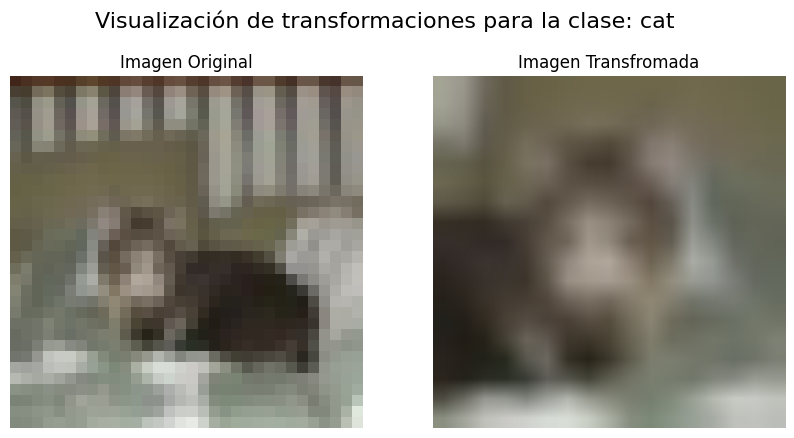

In [8]:
# --- Llamada a la función de visualización ---
# Muestra una imagen de ejemplo del dataset de entrenamiento.
# Puedes cambiar el índice (por ejemplo, 50) para ver diferentes imágenes.
visualize_transforms(image_datasets['train'], 150)

In [9]:

# --- 4. Carga y modificación del modelo pre-entrenado ---
# Descarga el modelo ResNet-18 pre-entrenado en ImageNet
model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [10]:

# Congela todos los parámetros de la red
# Esto evita que los pesos de las capas pre-entrenadas se actualicen
for param in model_ft.parameters():
    param.requires_grad = False

In [11]:

# Reemplaza la capa completamente conectada (fc)
# La capa 'fc' es la última capa de clasificación.
# 'model_ft.fc.in_features' obtiene el número de entradas de la capa original.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

In [12]:
# Mueve el modelo al dispositivo (GPU o CPU)
model_ft = model_ft.to(device)


In [13]:
# --- 4. Define la función de pérdida y el optimizador ---
# Solo los parámetros de la nueva capa 'fc' tienen requires_grad=True, por lo que
# el optimizador solo actualizará esos parámetros.
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

In [14]:


# --- 5. Bucle de entrenamiento ---
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Cada epoch tiene una fase de entrenamiento y una de validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Pone el modelo en modo de entrenamiento
            else:
                model.eval()   # Pone el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Itera sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Pone a cero los gradientes
                optimizer.zero_grad()

                # Solo hacia adelante
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Hacia atrás + optimización solo si estamos en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Entrenamiento completado')
    return model



Lo siguiente tarda en correr unos 10 minutos en entorno GPU T4 de Colab

In [15]:
# Entrena el modelo
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)


Epoch 0/4
----------
train Loss: 1.3348 Acc: 0.5333
val Loss: 0.8230 Acc: 0.7145
Epoch 1/4
----------
train Loss: 1.1996 Acc: 0.5799
val Loss: 0.7763 Acc: 0.7355
Epoch 2/4
----------
train Loss: 1.1866 Acc: 0.5869
val Loss: 0.7592 Acc: 0.7392
Epoch 3/4
----------
train Loss: 1.1809 Acc: 0.5891
val Loss: 0.7685 Acc: 0.7393
Epoch 4/4
----------
train Loss: 1.1653 Acc: 0.5954
val Loss: 0.7319 Acc: 0.7498
Entrenamiento completado


In [16]:

# Opcional: Guarda el modelo entrenado
torch.save(model_ft.state_dict(), 'transfer_learning_model.pth')

print("El modelo ha sido entrenado y guardado.")

El modelo ha sido entrenado y guardado.


In [ ]:
# chequear si se guardo

## Ajustar la ConvNet (Finetuning the ConvNet)

En lugar de una inicialización aleatoria, inicializamos la red con una red preentrenada, como la que se entrena con el conjunto de datos ImagenNet 1000. El resto del entrenamiento se desarrolla de forma normal.


Tome una ConvNet preentrenada en ImageNet, elimine la última capa completamente conectada (los resultados de esta capa son las 1000 puntuaciones de clase para una tarea diferente, como ImageNet) y trate el resto de la ConvNet como un extractor de características fijas para el nuevo conjunto de datos. En una AlexNet, esto calcularía un vector 4096-D para cada imagen que contenga las activaciones de la capa oculta inmediatamente antes del clasificador. Estas características se denominan códigos CNN. Es importante para el rendimiento que estos códigos sean ReLUd (es decir, umbralizados a cero) si también se umbralizaron durante el entrenamiento de la ConvNet en ImageNet (como suele ser el caso). Una vez extraídos los códigos 4096-D de todas las imágenes, entrene un clasificador lineal (por ejemplo, un clasificador SVM lineal o un clasificador Softmax) para el nuevo conjunto de datos.

